<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/Dynamic_Renko.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

                        Open     High      Low    Close      Volume
Date                                                               
2023-11-25 00:00:00  2080.00  2088.83  2075.00  2088.00   77.374171
2023-11-25 04:00:00  2086.40  2089.23  2080.85  2088.95   31.978040
2023-11-25 08:00:00  2088.96  2090.11  2066.97  2070.33   76.537614
2023-11-25 12:00:00  2070.50  2078.75  2068.87  2077.78   39.350536
2023-11-25 16:00:00  2079.20  2083.90  2074.19  2083.37  122.214851
...                      ...      ...      ...      ...         ...
2024-03-23 04:00:00  3303.94  3383.23  3303.94  3361.68   50.937661
2024-03-23 08:00:00  3372.74  3378.95  3330.09  3361.07  101.156426
2024-03-23 12:00:00  3361.96  3420.14  3347.06  3406.98  285.610821
2024-03-23 16:00:00  3398.31  3430.81  3385.33  3388.29  107.170204
2024-03-23 20:00:00  3388.93  3396.86  3354.48  3356.52  132.039619

[720 rows x 5 columns]


/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


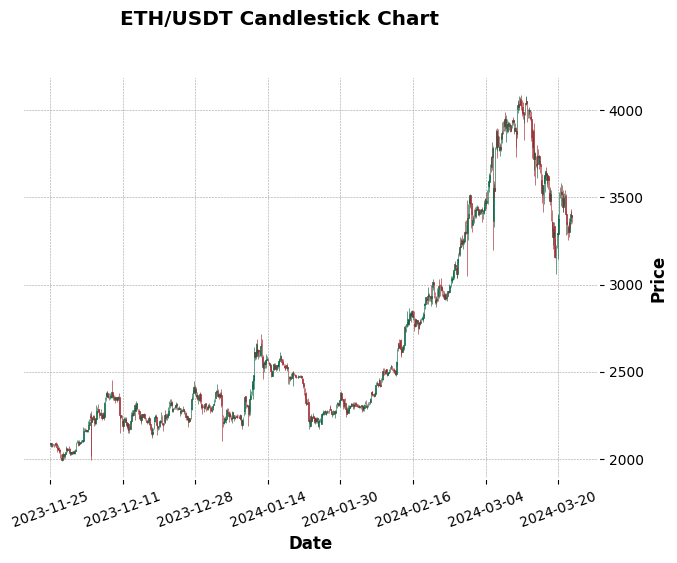

brick size: 20
                   Date    Open    High     Low   Close  uptrend
0   2023-11-27 08:00:00  2000.0  2020.0  2000.0  2020.0     True
1   2023-11-28 16:00:00  2020.0  2040.0  2020.0  2040.0     True
2   2023-12-01 00:00:00  2040.0  2060.0  2040.0  2060.0     True
3   2023-12-01 00:00:00  2060.0  2080.0  2060.0  2080.0     True
4   2023-12-02 12:00:00  2080.0  2100.0  2080.0  2100.0     True
..                  ...     ...     ...     ...     ...      ...
437 2024-03-22 20:00:00  3360.0  3360.0  3340.0  3340.0    False
438 2024-03-23 00:00:00  3340.0  3340.0  3320.0  3320.0    False
439 2024-03-23 04:00:00  3340.0  3360.0  3340.0  3360.0     True
440 2024-03-23 12:00:00  3360.0  3380.0  3360.0  3380.0     True
441 2024-03-23 12:00:00  3380.0  3400.0  3380.0  3400.0     True

[442 rows x 6 columns]
                       Open    High     Low   Close  uptrend  signals  \
Date                                                                    
2023-11-27 08:00:00  2000.0  2020.0

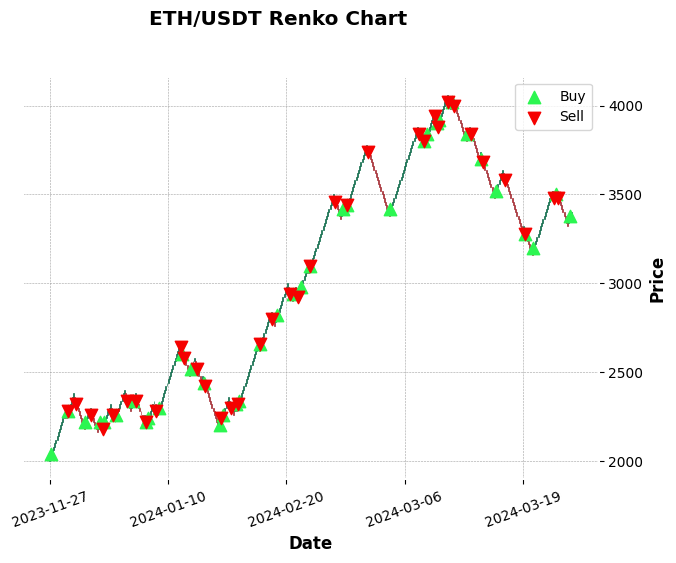

Overall P/L: 614.90%
Overall P/L: 614.90
Min balance: 100.00
Max balance: 714.90
Maximum Drawdown: -6.99
Maximum Drawdown %: -1.49%
                       Open    High     Low   Close  uptrend  signals  \
Date                                                                    
2023-11-27 08:00:00  2000.0  2020.0  2000.0  2020.0     True      0.0   
2023-11-28 16:00:00  2020.0  2040.0  2020.0  2040.0     True      1.0   
2023-12-01 00:00:00  2040.0  2060.0  2040.0  2060.0     True      1.0   
2023-12-01 00:00:00  2060.0  2080.0  2060.0  2080.0     True      1.0   
2023-12-02 12:00:00  2080.0  2100.0  2080.0  2100.0     True      1.0   
...                     ...     ...     ...     ...      ...      ...   
2024-03-22 20:00:00  3360.0  3360.0  3340.0  3340.0    False     -1.0   
2024-03-23 00:00:00  3340.0  3340.0  3320.0  3320.0    False     -1.0   
2024-03-23 04:00:00  3340.0  3360.0  3340.0  3360.0     True     -1.0   
2024-03-23 12:00:00  3360.0  3380.0  3360.0  3380.0     True     

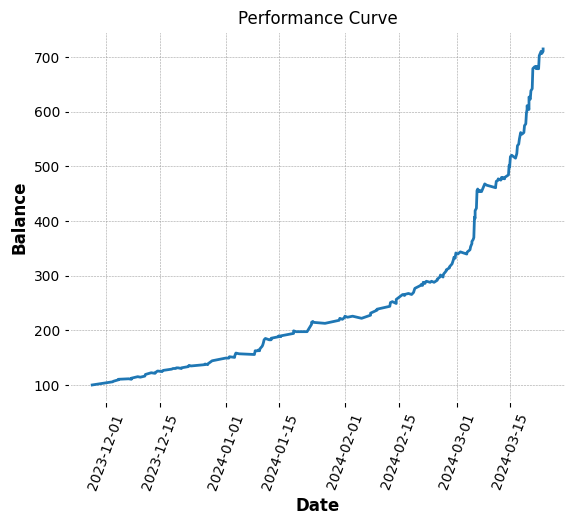

In [7]:
!pip install ccxt pandas pandas_ta stocktrends numpy scipy mplfinance matplotlib

import ccxt
from datetime import datetime
import pandas as pd
import pandas_ta as ta
from stocktrends import Renko
import numpy as np
import scipy.optimize as opt
import mplfinance as mpf
import matplotlib.pyplot as plt

def fetch_asset_data(symbol, start_date, interval, exchange):
    # Convert start_date to milliseconds timestamp
    start_date_ms = exchange.parse8601(start_date)

#   exchenge = ccxt.binance()
    exchange = ccxt.kraken()
    ohlcv = exchange.fetch_ohlcv(symbol, interval, since=start_date_ms)
#    ohlcv = exchange.kraken(symbol, interval, since=start_date_ms)
    header = ["Date", "Open", "High", "Low", "Close", "Volume"]
    df = pd.DataFrame(ohlcv, columns=header)
    df['Date'] = pd.to_datetime(df['Date'], unit='ms')
    df.set_index("Date", inplace=True)
    return df


def renko_data(data):  # Get the Renko data
    # For a stable backtest we need to drop tha last row of the dataframe
    # This is because you want to backtest with any live candles
    # In this case the CCXT's last data points (last row) is live so that's why we need to drop it
    # In other words you want completed candles
    data.drop(data.index[-1], inplace=True)

    data['ATR'] = ta.atr(high=data['High'], low=data['Low'], close=data['Close'], length=14)
    data.dropna(inplace=True)

    def evaluate_brick_size_atr(brick_size, atr_values):
        # Calculate number of bricks based on ATR and brick size
        num_bricks = atr_values // brick_size
        return np.sum(num_bricks)

    # Get optimised brick size
    brick = opt.fminbound(lambda x: -evaluate_brick_size_atr(x, data['ATR']), np.min(
        data['ATR']), np.max(data['ATR']), disp=0)

    def custom_round(number):
        # List of available rounding values
        rounding_values = [0.001, 0.005, 0.01, 0.05,
                           0.1, 0.5, 1] + list(range(5, 100, 5))
        rounding_values += list(range(100, 1000, 50)) + \
            list(range(1000, 10000, 100))

        # Finding the closest rounding value
        closest_value = min(rounding_values, key=lambda x: abs(x - number))
        return closest_value
    brick_size = custom_round(brick)
    print(f'brick size: {brick_size}')
    data.reset_index(inplace=True)
    data.columns = [i.lower() for i in data.columns]
    df = Renko(data)
    df.brick_size = brick_size
    renko_df = df.get_ohlc_data()

    # Capitalize the Column names for ohlc
    renko_df.rename(columns={'date': 'Date', 'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close'}, inplace=True)

    # Return the ohlc colums to floats
    renko_df['Open'] = renko_df['Open'].astype(float)
    renko_df['High'] = renko_df['High'].astype(float)
    renko_df['Low'] = renko_df['Low'].astype(float)
    renko_df['Close'] = renko_df['Close'].astype(float)
    return renko_df


def generate_positions(renko_df):
    # Rename the index of the renko data to brick
    renko_df.index.name = "brick"

    # Initialize signals list with 0 (no signal) for the first brick
    signals = []

    for i in range(0, len(renko_df)):
        # Get the current and previous brick colors
        is_current_green = renko_df['Close'].iloc[i] > renko_df['Open'].iloc[i]
        is_prev_green = renko_df['Close'].iloc[i -
                                               1] > renko_df['Open'].iloc[i - 1]

        if is_current_green and not is_prev_green:
            signals.append(1)  # Buy signal when the brick changes to green
        elif is_current_green and is_prev_green:
            signals.append(1)  # Hold signal when the brick remains green
        elif not is_current_green and is_prev_green:
            signals.append(-1)  # Sell signal when the brick changes to red
        elif not is_current_green and not is_prev_green:
            signals.append(-1)  # Hold signal when the brick remains red

     # Add the 'signals' column to the DataFrame
    renko_df['signals'] = signals
    renko_df['signals'] = renko_df["signals"].shift(1) #Remove look ahead bias
    renko_df.fillna(0.0, inplace=True)
    renko_df.set_index("Date", inplace=True)

    # Create the Positions
    # Initialize positions with nan
    renko_df['buy_positions'] = np.nan
    renko_df['sell_positions'] = np.nan

    renko_df.index.freq = pd.infer_freq(renko_df.index)

   # Update the buy_positions with the close price where the signal is 1 and the previous signal is not equal to the current signal
    buy_signal_indices = renko_df[(renko_df['signals'] == 1) & (renko_df['signals'] != renko_df['signals'].shift(1))].index
    renko_df.loc[buy_signal_indices, 'buy_positions'] = renko_df.loc[buy_signal_indices, 'Close']

    # Update the sell_positions with close price where the signal is -1 and the previous signal is not equal to the current signal
    sell_signal_indices = renko_df[(renko_df['signals'] == -1) & (renko_df['signals'] != renko_df['signals'].shift(1))].index
    renko_df.loc[sell_signal_indices, 'sell_positions'] = renko_df.loc[sell_signal_indices, 'Close']

    # Reset duplicate dates in the positions to nan, i.e where the previous date is equal to the current date
    renko_df.loc[renko_df.index == pd.Series(renko_df.index).shift(1), ['buy_positions', 'sell_positions']] = np.nan

    return renko_df

# calculate the performance
def calculate_strategy_performance(strategy_df, capital=100, leverage=1):
    # Initialize the performance variables
    cumulative_balance = capital
    investment = capital
    pl = 0
    max_drawdown = 0
    max_drawdown_percentage = 0

    # Lists to store intermediate values for calculating metrics
    balance_list = [capital]
    pnl_list = [0]
    investment_list = [capital]
    peak_balance = capital

    # Loop from the second row (index 1) of the DataFrame
    for index in range(1, len(strategy_df)):
        row = strategy_df.iloc[index]

        # Calculate P/L for each trade signal
        if row['signals'] == 1:
            pl = ((row['Close'] - row['Open']) / row['Open']) * \
                investment * leverage
        elif row['signals'] == -1:
            pl = ((row['Open'] - row['Close']) / row['Close']) * \
                investment * leverage
        else:
            pl = 0

        # Update the investment if there is a signal reversal
        if row['signals'] != strategy_df.iloc[index - 1]['signals']:
            investment = cumulative_balance

        # Calculate the new balance based on P/L and leverage
        cumulative_balance += pl

        # Update the investment list
        investment_list.append(investment)

        # Calculate the cumulative balance and add it to the DataFrame
        balance_list.append(cumulative_balance)

        # Calculate the overall P/L and add it to the DataFrame
        pnl_list.append(pl)

        # Calculate max drawdown
        drawdown = cumulative_balance - peak_balance
        if drawdown < max_drawdown:
            max_drawdown = drawdown
            max_drawdown_percentage = (max_drawdown / peak_balance) * 100

        # Update the peak balance
        if cumulative_balance > peak_balance:
            peak_balance = cumulative_balance

    # Add new columns to the DataFrame
    strategy_df['investment'] = investment_list
    strategy_df['cumulative_balance'] = balance_list
    strategy_df['pl'] = pnl_list
    strategy_df['cumPL'] = strategy_df['pl'].cumsum()

    # Calculate other performance metrics (replace with your calculations)
    overall_pl_percentage = (
        strategy_df['cumulative_balance'].iloc[-1] - capital) * 100 / capital
    overall_pl = strategy_df['cumulative_balance'].iloc[-1] - capital
    min_balance = min(strategy_df['cumulative_balance'])
    max_balance = max(strategy_df['cumulative_balance'])

    # Print the performance metrics
    print("Overall P/L: {:.2f}%".format(overall_pl_percentage))
    print("Overall P/L: {:.2f}".format(overall_pl))
    print("Min balance: {:.2f}".format(min_balance))
    print("Max balance: {:.2f}".format(max_balance))
    print("Maximum Drawdown: {:.2f}".format(max_drawdown))
    print("Maximum Drawdown %: {:.2f}%".format(max_drawdown_percentage))

    # Return the Strategy DataFrame
    return strategy_df


# Plot the Candlestick data, the buy and sell signal markers
def plot_candlestick(df):
    # Plot the candlestick chart
    mpf.plot(df, type='candle', style='charles', datetime_format='%Y-%m-%d', xrotation=20,
             title=str(symbol + ' Candlestick Chart'), ylabel='Price', xlabel='Date', scale_width_adjustment=dict(candle=2))


# Plot the Renko Data.
def plot_renko(renko_df):
    # Plot the Renko Chart
    adp = [mpf.make_addplot(renko_df['buy_positions'], type='scatter', marker='^', label= "Buy", markersize=80, color='#2cf651'),
      mpf.make_addplot(renko_df['sell_positions'], type='scatter', marker='v', label= "Sell", markersize=80, color='#f50100')
     ]
    mpf.plot(renko_df, addplot=adp, type='candle', style='charles', datetime_format='%Y-%m-%d', xrotation=20,
             title=str(symbol + ' Renko Chart'), ylabel='Price', xlabel='Date', scale_width_adjustment=dict(candle=2))

# Plot the performance curve
def plot_performance_curve(strategy_df):
    # Plot the performance curve
    plt.plot(strategy_df['cumulative_balance'])
    plt.title('Performance Curve')
    plt.xlabel('Date')
    plt.ylabel('Balance')
    plt.xticks(rotation=70)
    plt.show()

if __name__ == "__main__":
    # Define the symbol, start date, interval and exchange
    symbol = "ETH/USDT"
    start_date = "2022-12-1"
    interval = '4h'
    exchange = ccxt.binance()

    # Fetch the historical data and Convert the data to a Pandas dataframe
    data = fetch_asset_data(symbol=symbol, start_date=start_date, interval=interval, exchange=exchange)

    # Print the asset dataframe
    print(data)

    # Plot the Symbol data candlestick chart
    plot_candlestick(df=data)

    # Get the Renko Bricks
    renko_df = renko_data(data)
    print(renko_df)

    # Generate Strategy Signals
    positions_df = generate_positions(renko_df)
    print(positions_df)

    # Plot the Renko Bricks and Positions
    plot_renko(renko_df)

    # Calculate Strategy Performance
    strategy_df = calculate_strategy_performance(positions_df)
    print(strategy_df)

    # Plot the performance curve
    plot_performance_curve(strategy_df)